In [4]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import os
import cv2
import glob

In [5]:
data_dir = '/home/aracely/aitraveling/cities'
labels = ["agra", "cdmx", "newyork", "paris", "shanhaiguan"]
for label in labels:
    image_count = len(glob.glob(data_dir+"/"+label+"/*"))
    print(label+": "+str(image_count))

agra: 300
cdmx: 299
newyork: 300
paris: 300
shanhaiguan: 300


In [6]:
images = {}
for label in labels:
    images[label] = glob.glob(data_dir+"/"+label+"/*")
# imgs_china = glob.glob(data_dir+"/china/*")
# imgs_india = glob.glob(data_dir+"/india/*")
# imgs_mexico = glob.glob(data_dir+"/mexico/*")

In [7]:
len(images)

5

In [8]:
print(len(images["agra"]))

300


## Load data using a Keras utility

### Create a dataset

In [9]:
batch_size = 32
img_height = 180
img_width = 180

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1500 files belonging to 5 classes.
Using 1200 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1500 files belonging to 5 classes.
Using 300 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['agra', 'cdmx', 'newyork', 'paris', 'shanhaiguan']


## Visualize the data

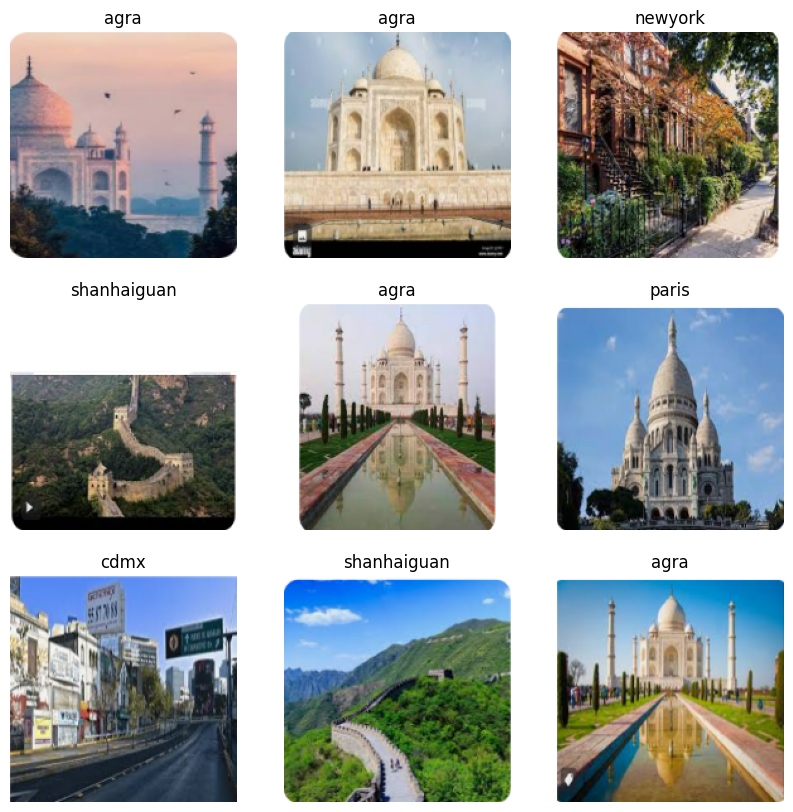

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


## Configure the dataset for performance

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

In [16]:
normalization_layer = layers.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


## A basic Keras model

### Create the model

In [18]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [21]:
epochs=12
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/12
38/38 [==============================] - 14s 327ms/step - loss: 1.5487 - accuracy: 0.3675 - val_loss: 1.4011 - val_accuracy: 0.4000
Epoch 2/12
38/38 [==============================] - 12s 306ms/step - loss: 1.1965 - accuracy: 0.5317 - val_loss: 1.2728 - val_accuracy: 0.4933
Epoch 3/12
38/38 [==============================] - 12s 312ms/step - loss: 0.9275 - accuracy: 0.6492 - val_loss: 1.0445 - val_accuracy: 0.5633
Epoch 4/12
38/38 [==============================] - 12s 323ms/step - loss: 0.7182 - accuracy: 0.7342 - val_loss: 0.9157 - val_accuracy: 0.6233
Epoch 5/12
38/38 [==============================] - 12s 305ms/step - loss: 0.5298 - accuracy: 0.8217 - val_loss: 0.9093 - val_accuracy: 0.6500
Epoch 6/12
38/38 [==============================] - 12s 310ms/step - loss: 0.3305 - accuracy: 0.8900 - val_loss: 0.9245 - val_accuracy: 0.6400
Epoch 7/12
38/38 [==============================] - 12s 309ms/step - loss: 0.1877 - accuracy: 0.9483 - val_loss: 1.0771 - val_accuracy: 0.6567

## Visualize training results

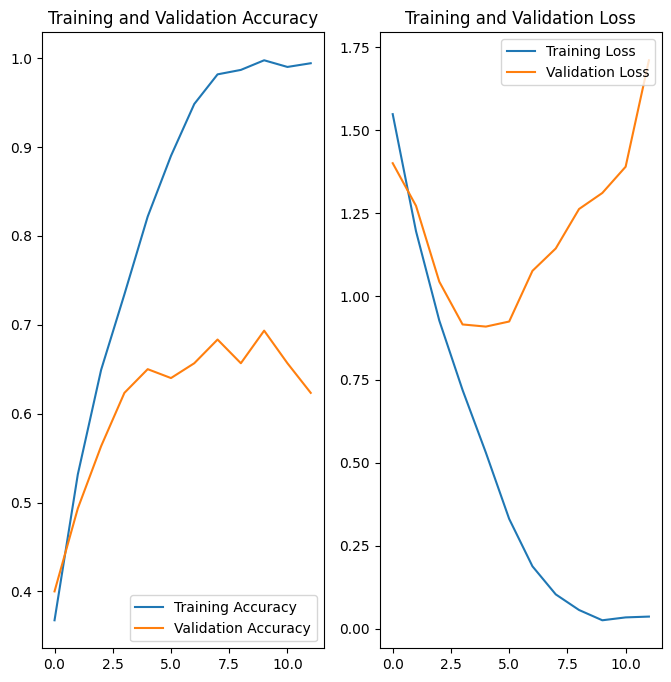

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Data augmentation

In [138]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

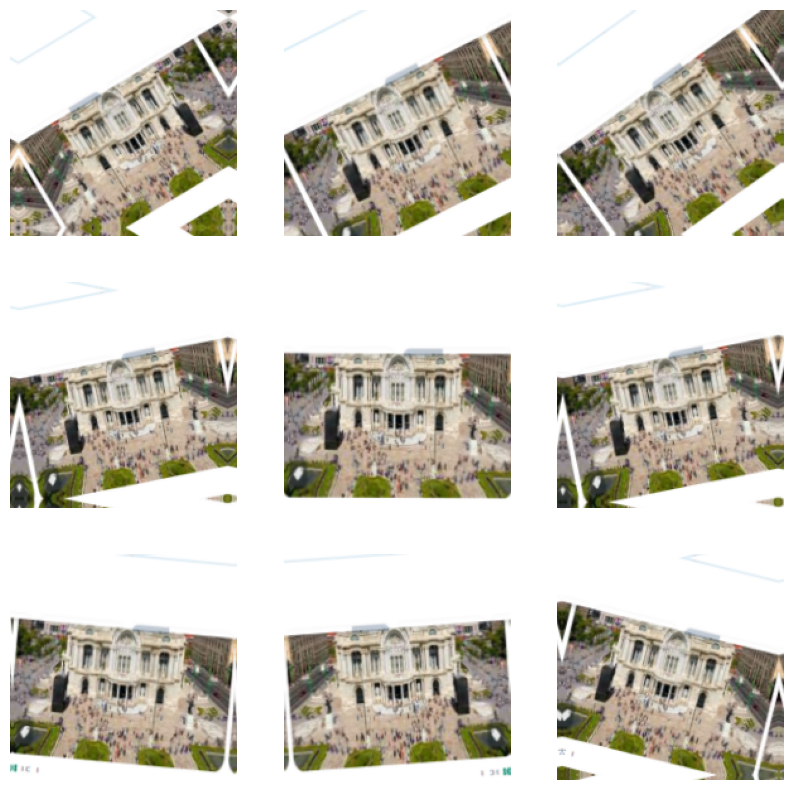

In [139]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [140]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [141]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [142]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_11 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                               

In [143]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
38/38 [==============================] - 14s 333ms/step - loss: 1.6397 - accuracy: 0.2608 - val_loss: 1.4952 - val_accuracy: 0.3533
Epoch 2/15
38/38 [==============================] - 12s 307ms/step - loss: 1.4208 - accuracy: 0.4158 - val_loss: 1.3265 - val_accuracy: 0.4167
Epoch 3/15
38/38 [==============================] - 11s 286ms/step - loss: 1.2305 - accuracy: 0.4917 - val_loss: 1.2192 - val_accuracy: 0.4767
Epoch 4/15
38/38 [==============================] - 10s 269ms/step - loss: 1.1608 - accuracy: 0.5408 - val_loss: 1.2771 - val_accuracy: 0.5033
Epoch 5/15
38/38 [==============================] - 11s 278ms/step - loss: 1.1361 - accuracy: 0.5608 - val_loss: 1.0448 - val_accuracy: 0.5633
Epoch 6/15
38/38 [==============================] - 10s 267ms/step - loss: 1.0191 - accuracy: 0.6067 - val_loss: 1.0088 - val_accuracy: 0.5967
Epoch 7/15
38/38 [==============================] - 10s 260ms/step - loss: 0.9729 - accuracy: 0.6217 - val_loss: 0.9385 - val_accuracy: 0.6300

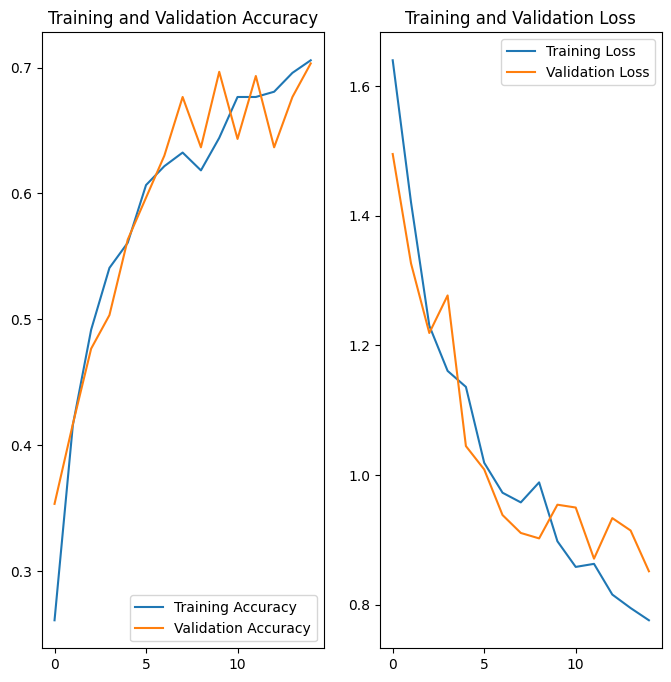

In [144]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

In [145]:
data_dir

'/home/aracely/aitraveling/cities'

1/1 [==============================] - 0s 71ms/step
This image most likely belongs to agra with a 95.22 percent confidence.

['agra', 'cdmx', 'newyork', 'paris', 'shanhaiguan']
[0.9521993  0.02658388 0.01188658 0.00545947 0.00387086]


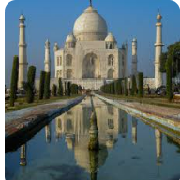

In [146]:
img = tf.keras.utils.load_img(
    data_dir+'/agra/(10403).png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
print()
print(class_names)
# print(type(score))
print(np.array(score))
img

1/1 [==============================] - 0s 27ms/step
This image most likely belongs to cdmx with a 41.02 percent confidence.

['agra', 'cdmx', 'newyork', 'paris', 'shanhaiguan']
[0.00086883 0.4101586  0.2242885  0.36189535 0.00278881]


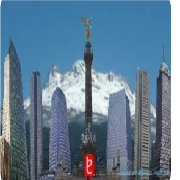

In [147]:
img2 = tf.keras.utils.load_img(
    data_dir+'/cdmx/(10130).png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img2)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print()
print(class_names)
# print(type(score))
print(np.array(score))
img2

1/1 [==============================] - 0s 35ms/step
This image most likely belongs to newyork with a 96.57 percent confidence.

['agra', 'cdmx', 'newyork', 'paris', 'shanhaiguan']
[1.3907925e-04 6.3300882e-03 9.6573067e-01 2.7790146e-02 1.0029859e-05]


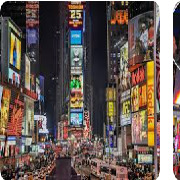

In [149]:
img3 = tf.keras.utils.load_img(
    data_dir+'/newyork/(1087).png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img3)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print()
print(class_names)
# print(type(score))
print(np.array(score))
img3

1/1 [==============================] - 0s 33ms/step
This image most likely belongs to paris with a 93.65 percent confidence.

['agra', 'cdmx', 'newyork', 'paris', 'shanhaiguan']
[0.00711079 0.02227398 0.00718912 0.93647426 0.0269519 ]


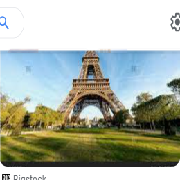

In [150]:
img4 = tf.keras.utils.load_img(
    data_dir+'/paris/(10239).png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img4)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print()
print(class_names)
# print(type(score))
print(np.array(score))
img4

1/1 [==============================] - 0s 33ms/step
This image most likely belongs to shanhaiguan with a 94.35 percent confidence.

['agra', 'cdmx', 'newyork', 'paris', 'shanhaiguan']
[1.9418764e-04 3.4201887e-02 2.0982910e-02 1.1465357e-03 9.4347447e-01]


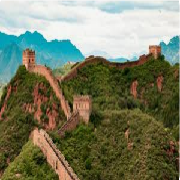

In [151]:
img5 = tf.keras.utils.load_img(
    data_dir+'/shanhaiguan/(10431).png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img5)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print()
print(class_names)
# print(type(score))
print(np.array(score))
img5

1/1 [==============================] - 0s 24ms/step
This image most likely belongs to shanhaiguan with a 94.35 percent confidence.

['agra', 'cdmx', 'newyork', 'paris', 'shanhaiguan']
[1.9418764e-04 3.4201887e-02 2.0982910e-02 1.1465357e-03 9.4347447e-01]


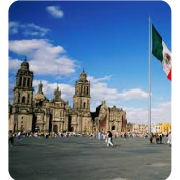

In [152]:
img = tf.keras.utils.load_img(
    data_dir+'/cdmx/(17155).png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img5)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print()
print(class_names)
# print(type(score))
print(np.array(score))
img

## Use TensorFlow Lite

### Convert the Keras Sequential model to a TensorFlow Lite model


In [160]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model5.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpvjbtng85/assets


INFO:tensorflow:Assets written to: /tmp/tmpvjbtng85/assets
2024-02-24 12:58:36.982019: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-24 12:58:36.982083: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-24 12:58:36.982253: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpvjbtng85
2024-02-24 12:58:36.984658: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-24 12:58:36.984686: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpvjbtng85
2024-02-24 12:58:36.992246: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-24 12:58:37.082458: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpvjbtng85
2024-02-24 12:58:37.100326: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

### Run the TensorFlow Lite model

In [154]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [155]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_7_input'], 'outputs': ['outputs']}}

In [156]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [157]:
predictions_lite = classify_lite(sequential_7_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

1/1 [==============================] - 0s 27ms/step
This image most likely belongs to shanhaiguan with a 94.35 percent confidence.

['agra', 'cdmx', 'newyork', 'paris', 'shanhaiguan']
[1.9418764e-04 3.4201887e-02 2.0982910e-02 1.1465357e-03 9.4347447e-01]


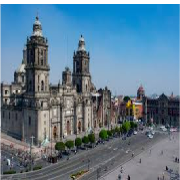

In [158]:
img = tf.keras.utils.load_img(
    data_dir+'/cdmx/(17503).png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img5)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print()
print(class_names)
# print(type(score))
print(np.array(score))
img